เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
[ 7  5 21  1 36 28 15  8 30 22 20 29 25 11  3 14 12 35 33 17 34 32 13  0
 23  6 37 18 19 26 10 27 16  9 24  4  2 31]
[20 23  9 35  3  6 15  8 34 36 24  0 27 28 21 33 11  7  4 25 19 29 12 37
 17 14 31 10 26 18 13  5  1 16 22  2 30 32]
[25 22  0  2  9 15 32 31 30 14 36 17 34 24  8 21 20 19 26  6 23  1 11 16
 29 28 33  4 27 35  7 12 18  3  5 13 37 10]
[36 23  2 25 19 34 26 13 11 31 22 32  1 30  8 29 16 27 28 17  6 18 12  0
 20  7  3 37 24 35 14 33  9  4 10 15 21  5]
[36 11  9 33 29 32 15  7  6  5  1 27 22 12 21 18 28 20  8 14 30 17 23  0
 25  3 10 13  4 16  2 35 31 26 24 37 19 34]
[29 15  0 36  9  8 23  5 20 35 21 17 32 11  4 33 19 13 37 28  7 30  3 10
 14 27  1 34  2 24 31 12 26 22 16 18  6 25]
[20 23 32 34 26 19  2 25 33 28 35 24  7 11 15 12  9 27 18 36 16  1  6  0
 14  4  3 21 22 29 37  5  8 10 31 13 17 30]
[21  5 25 16  3 34 36 17 14 11 19 26 12  4 32 27 28 24  0  9  2  8 23 15
 30 13  1 31 20 29 10 33 37  7  6 18 22 35]
[ 0 27 

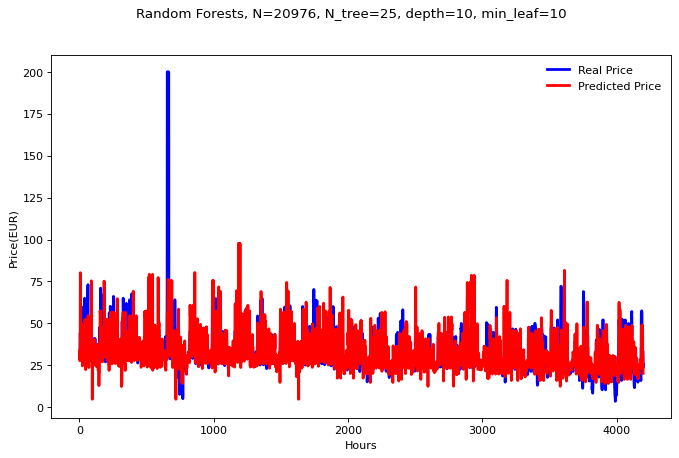

In [3]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

hour_ahead = 24
N_tree = 25
Depth = 15
Min_leaf = 1


path = "/content/drive/MyDrive/Colab Notebooks/Project/26_Merge_all_with_time.csv"
Merge_all = pd.read_csv(path)
dti = pd.to_datetime(Merge_all['DateTime'], format='%Y-%m-%d %H', exact=False)
Merge_all.set_index(pd.Index(dti), inplace=True)
Merge_all.drop(['DateTime'], axis=1, inplace=True)

First = Merge_all.iloc[0:21000, :]
N_index = First.shape
Y_temp = First['FI']
Y = Y_temp.iloc[hour_ahead:N_index[0]]
Y = Y.to_numpy()
#Y.reset_index(drop=True, inplace=True)
#Y.columns = [''] * len(Y.columns)


X_temp1 = First['FI']
X_temp2 = First.loc[:, First.columns != 'FI']
X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
X_temp2.set_index(X_temp2_index, inplace=True)
X_temp1 = X_temp1.to_frame()
X_temp = X_temp1.join(X_temp2)
X = X_temp.iloc[0:N_index[0] - hour_ahead]
X = X.to_numpy()
#X.reset_index(drop=True, inplace=True)
#X.columns = [''] * len(X.columns)
Pred_index = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

class RandomForest():
    def __init__(self, x, y, n_trees, n_features, sample_sz, depth=10, min_leaf=10):
        np.random.seed(12)
        if n_features == 'sqrt':
            self.n_features = int(np.sqrt(x.shape[1]))
        elif n_features == 'log2':
            self.n_features = int(np.log2(x.shape[1]))
        else:
            self.n_features = n_features
        print(self.n_features, "sha: ", x.shape[1])
        self.x, self.y, self.sample_sz, self.depth, self.min_leaf = x, y, sample_sz, depth, min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        f_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        return DecisionTree(self.x[idxs], self.y[idxs], self.n_features, f_idxs,
                            idxs=np.array(range(self.sample_sz)), depth=self.depth, min_leaf=self.min_leaf)

    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)


def std_agg(cnt, s1, s2):
    try:
        return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
    except:
        return 0


class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs, idxs, depth, min_leaf):
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        print(f_idxs)
        #         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_sum2: object
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi ** 2
            rhs_sum2 -= yi ** 2
            if i < self.min_leaf or xi == sort_x[i + 1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

train_index = X_train.shape
forests = RandomForest(X_train, y_train, N_tree, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
Pred = forests.predict(X_train)

print("hour_ahead = " + str(hour_ahead))
print("N_tree = " + str(N_tree))
print("Depth = " + str(Depth))
print("Min_leaf = " + str(Min_leaf))

MSE = mean_squared_error(y_train, Pred, squared=True)
print("Training MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Training RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_train, Pred)
print("Training MAE  " + str(MAE))


T_Pred = forests.predict(X_test)
MSE = mean_squared_error(y_test, T_Pred, squared=True)
print("Testing MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Testing RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_test, T_Pred)
print("Testing MAE  " + str(MAE))


plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('Random Forests, N=' + str(Pred_index[0]) + ', N_tree=' + str(N_tree) + ', depth=' + str(10) + ', min_leaf=' + str(10))
plt.plot(np.arange(len(y_test))+1, y_test, color="blue", linewidth=2.5, linestyle="-", label='Real Price')
plt.plot(np.arange(len(T_Pred))+1, T_Pred, color="red",  linewidth=2.5, linestyle="-", label='Predicted Price')
plt.xlabel('Hours')
plt.ylabel('Price(EUR)')
plt.legend(frameon=False)
plt.show()

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
[ 0 34 33 17 24 22 16  8  6 18 25  2 28 19  9 13 15 10  1 36  3 20 31  5
 32  4 11 37 30 27 23  7 21 29 26 35 12 14]
[28 19 16 21 17 18  3 22 37  6 14  1 11 24  0 30 32 12  9 31 25 10 20  4
 35 33 23  8  5 15 36  2 27 26 34 13  7 29]
[28 24 31 15 30 32 37 36  0  5  7  6 27 11 21 25 19  4  3 17  1 23 18 33
 16  8 34 12 13 35 26 14 22  2 10 20  9 29]
[35 24 20 17  4  0 31  8 19  5 23 14 28  1 13 11 15 27 30 10 12 26 29 22
 33  7  6 18  2 36 16 25 21 37  9  3 34 32]
[ 4  5 20 36 29 26 22  6 17 21 24 33  0 19 28 31 27 10 11 12  9 13 30  1
 23  3 35 15  7 18 32 16 34 25 14  2 37  8]
[33  6 14 28 12 15 18 17 31  5 34  8 26 35 11 24 27  4 20 30 22  3 19  0
 37 23 10 13 21 36  1 32 29  7 16  9  2 25]
[10 34 13 27 30 19 20  8 12  7 17 37 22 33 14 31  4  2 36 11  1 18 26 24
 28  3  9 25 21  5 29 16  0 23  6 35 32 15]
[ 5 12 24 10 28  2 20 11 25  9 26  8 22  6 33 36 15 21  0 35 14 31 34 27
 29  7  4  3 19 32 16 30 18 17 23 13  1 37]
[20  6 

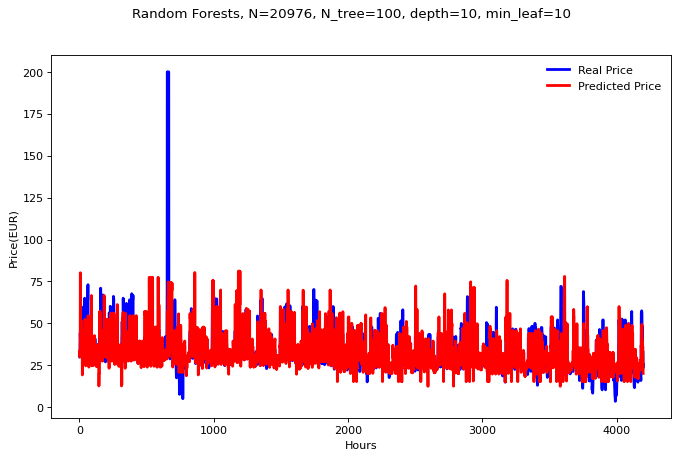

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

hour_ahead = 24
N_tree = 100
Depth = 15
Min_leaf = 2


path = "/content/drive/MyDrive/Colab Notebooks/Project/26_Merge_all_with_time.csv"
Merge_all = pd.read_csv(path)
dti = pd.to_datetime(Merge_all['DateTime'], format='%Y-%m-%d %H', exact=False)
Merge_all.set_index(pd.Index(dti), inplace=True)
Merge_all.drop(['DateTime'], axis=1, inplace=True)

First = Merge_all.iloc[0:21000, :]
N_index = First.shape
Y_temp = First['FI']
Y = Y_temp.iloc[hour_ahead:N_index[0]]
Y = Y.to_numpy()
#Y.reset_index(drop=True, inplace=True)
#Y.columns = [''] * len(Y.columns)


X_temp1 = First['FI']
X_temp2 = First.loc[:, First.columns != 'FI']
X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
X_temp2.set_index(X_temp2_index, inplace=True)
X_temp1 = X_temp1.to_frame()
X_temp = X_temp1.join(X_temp2)
X = X_temp.iloc[0:N_index[0] - hour_ahead]
X = X.to_numpy()
#X.reset_index(drop=True, inplace=True)
#X.columns = [''] * len(X.columns)
Pred_index = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

class RandomForest():
    def __init__(self, x, y, n_trees, n_features, sample_sz, depth=10, min_leaf=10):
        np.random.seed(12)
        if n_features == 'sqrt':
            self.n_features = int(np.sqrt(x.shape[1]))
        elif n_features == 'log2':
            self.n_features = int(np.log2(x.shape[1]))
        else:
            self.n_features = n_features
        print(self.n_features, "sha: ", x.shape[1])
        self.x, self.y, self.sample_sz, self.depth, self.min_leaf = x, y, sample_sz, depth, min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        f_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        return DecisionTree(self.x[idxs], self.y[idxs], self.n_features, f_idxs,
                            idxs=np.array(range(self.sample_sz)), depth=self.depth, min_leaf=self.min_leaf)

    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)


def std_agg(cnt, s1, s2):
    try:
        return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
    except:
        return 0


class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs, idxs, depth, min_leaf):
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        print(f_idxs)
        #         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_sum2: object
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi ** 2
            rhs_sum2 -= yi ** 2
            if i < self.min_leaf or xi == sort_x[i + 1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

train_index = X_train.shape
forests = RandomForest(X_train, y_train, N_tree, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
Pred = forests.predict(X_train)

print("hour_ahead = " + str(hour_ahead))
print("N_tree = " + str(N_tree))
print("Depth = " + str(Depth))
print("Min_leaf = " + str(Min_leaf))

MSE = mean_squared_error(y_train, Pred, squared=True)
print("Training MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Training RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_train, Pred)
print("Training MAE  " + str(MAE))


T_Pred = forests.predict(X_test)
MSE = mean_squared_error(y_test, T_Pred, squared=True)
print("Testing MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Testing RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_test, T_Pred)
print("Testing MAE  " + str(MAE))


plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('Random Forests, N=' + str(Pred_index[0]) + ', N_tree=' + str(N_tree) + ', depth=' + str(10) + ', min_leaf=' + str(10))
plt.plot(np.arange(len(y_test))+1, y_test, color="blue", linewidth=2.5, linestyle="-", label='Real Price')
plt.plot(np.arange(len(T_Pred))+1, T_Pred, color="red",  linewidth=2.5, linestyle="-", label='Predicted Price')
plt.xlabel('Hours')
plt.ylabel('Price(EUR)')
plt.legend(frameon=False)
plt.show()